In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import re

# Primary Color Palette
primary_color = "#2B2D42"
secondary_color = "#8D99AE"
accent_color = "#EF233C"
background_color = "#EDF2F4"
text_color = "#333333"

# Additional Colors
highlight_color = "#D90429"
info_color = "#3A86FF"
success_color = "#06D6A0"
warning_color = "#FFD166"
error_color = "#FF4B4B"

# Custom Chart Colors
chart_color_1 = "#264653" 
chart_color_2 = "#2A9D8F"
chart_color_3 = "#E9C46A"
chart_color_4 = "#F4A261"
chart_color_5 = "#E76F51" 

# Set the color palette
sns.set_palette(sns.color_palette([primary_color, accent_color]))

# Set the style
sns.set_style("whitegrid")

# Set the context
sns.set_context("notebook")

,Car-Model,Date,Registrations
0,Abarth <070022>,May 2008,5
1,Abarth <070022>,June 2008,4
2,Abarth <070022>,July 2008,20
3,Abarth <070022>,August 2008,15
4,Abarth <070022>,September 2008,11
...,...,...,...
21375,Others <..9999>,December 2012,1
21376,Others <..9999>,March 2014,1
21377,Others <..9999>,July 2016,1
21378,Others <..9999>,June 2019,1


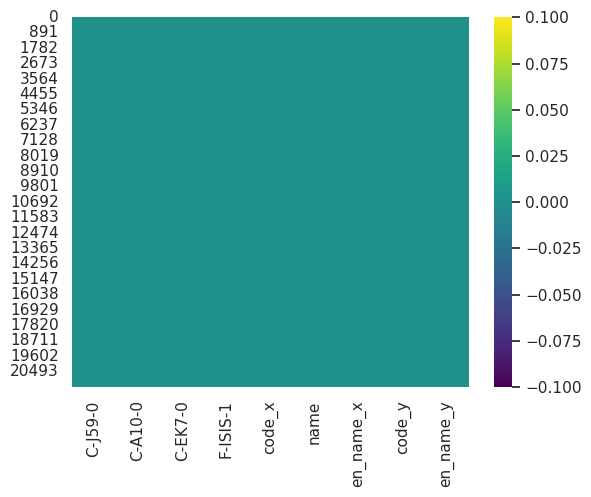

In [15]:
df_nmb_of_registrations = pd.read_csv('Data/OGD_fkfzul0759_OD_PkwNZL_1.csv', sep=';')


df_monthly_values = pd.read_csv('Data/OGD_fkfzul0759_OD_PkwNZL_1_C-A10-0.csv', sep=';')
df_monthly_values = df_monthly_values[['code', 'name', 'en_name']]

df_car_name = pd.read_csv('Data/OGD_fkfzul0759_OD_PkwNZL_1_C-J59-0.csv', sep=';')
df_car_name = df_car_name[['code', 'en_name']]

# Merge both datasets to one
merged_data = pd.merge(df_nmb_of_registrations, df_monthly_values, left_on='C-A10-0', right_on='code', how='left')
merged_data = pd.merge(merged_data, df_car_name, left_on='C-J59-0', right_on='code', how='left')

sns.heatmap(merged_data.isnull(), cmap='viridis')

merged_data.drop(['C-EK7-0', 'code_x', 'code_y', 'C-A10-0',  'C-J59-0', 'name' ], axis=1, inplace=True)
merged_data.rename(columns={'F-ISIS-1': 'Registrations', 'en_name_x': 'Date', 'en_name_y': 'Car-Model'}, inplace=True)

merged_data = merged_data[['Car-Model', 'Date', 'Registrations']]
merged_data

In [16]:
rows_with_nan = merged_data[merged_data.isna().any(axis=1)]

print("Following rows have missing values which have to be removed (No Date, No Registration numbers): ")
if rows_with_nan.empty:
    print("No missing values where found")
else:
    merged_data = merged_data.dropna()
    print(rows_with_nan)

merged_data['Car-Model'] = merged_data['Car-Model'].str.replace(r'<.*?>|\d+', '', regex=True)
merged_data['Car-Model'] = merged_data['Car-Model'].str.strip()

# Removing special characters 
special_char_pattern = r'[^a-zA-Z0-9äöüÄÖÜß\s-]'
columns_to_check = ['Registrations', 'Date']

for column in columns_to_check:
    merged_data[column] = merged_data[column].astype(str)
    special_char_rows = merged_data[merged_data[column].str.contains(special_char_pattern, regex=True, na=False)]
    count_special_chars = special_char_rows.shape[0]
    merged_data[column] = merged_data[column].str.replace(special_char_pattern, '', regex=True)
    print(f"Special characters where found at {column}: {count_special_chars} Zeilen")

# Changing after the check the column 'Registration' back to an Int
merged_data['Registrations'] = merged_data['Registrations'].astype(int)

merged_data.to_csv('export/Car_registrations_by_name_and_date.csv', index=False)


Following rows have missing values which have to be removed (No Date, No Registration numbers): 
No missing values where found
Special characters where found at Registrations: 0 Zeilen
Special characters where found at Date: 72 Zeilen


In [17]:
#E2
## Global vizualization and general statistic plots 

# Convert date into date time format to procces easier the informations
merged_data['Date'] = pd.to_datetime(merged_data['Date'], format='mixed', errors='coerce')


# Filtering the data to get all Information till 2024 
filtered_data = merged_data[merged_data['Date'].dt.year <= 2024]

# Grouping registration for every month and sum the information
registrations_per_month = filtered_data.groupby(filtered_data['Date'].dt.to_period('M'))['Registrations'].sum()


# Converting the period index into a string to make it JSON compabile
registrations_per_month.index = registrations_per_month.index.astype(str)
merged_data
# Creating the interactiv Plot with Plotly
fig = px.line(
    x=registrations_per_month.index, 
    y=registrations_per_month.values, 
    title="Registration per Month (2000 till 2024)",
    labels={'x': 'Date', 'y': 'Amount of registrations'},
    # color_discrete_sequence=[chart_color_2],  # Changing the line color if neccessary 
)

# Updating the layout to our standards 
fig.update_layout(
    plot_bgcolor=background_color,  # Background color 
    paper_bgcolor=background_color,  # Background color for the whole plot
    font=dict(color=text_color),     # Text color
    title_font=dict(size=18, color=text_color),
    xaxis=dict(showgrid=True, gridcolor=secondary_color),
    yaxis=dict(showgrid=True, gridcolor=secondary_color)
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [18]:
stat_description = merged_data['Registrations'].describe()
stat_description

count    21380.000000
mean       348.012395
std        675.809290
min          1.000000
25%         12.000000
50%         78.000000
75%        325.000000
max       7635.000000
Name: Registrations, dtype: float64

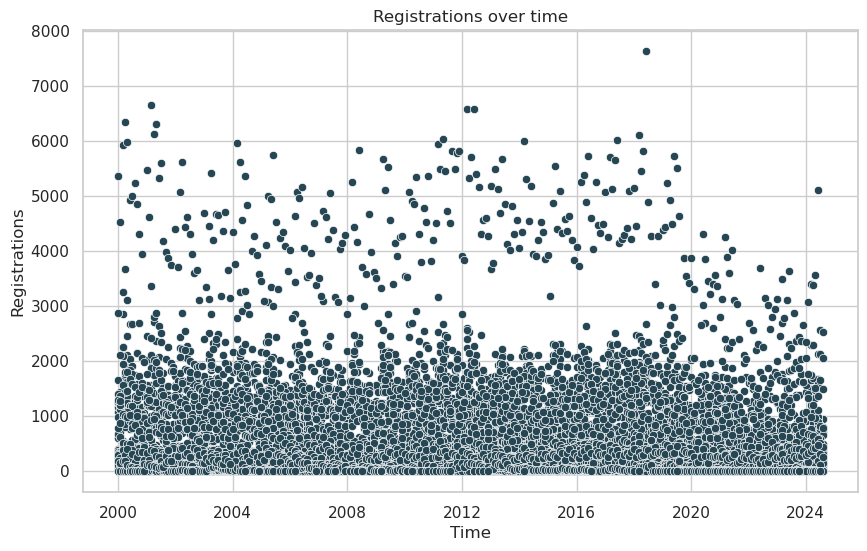

In [19]:
# A vizalization to get the registration over time (Time period 2000 - 2024)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_data['Date'], y=merged_data['Registrations'], color=chart_color_1)
plt.title("Registrations over time")
plt.xlabel("Date")
plt.ylabel("Registrations")
plt.show()

Korrelationsmatrix:
               Registrations  Date_numeric
Registrations        1.00000      -0.05791
Date_numeric        -0.05791       1.00000


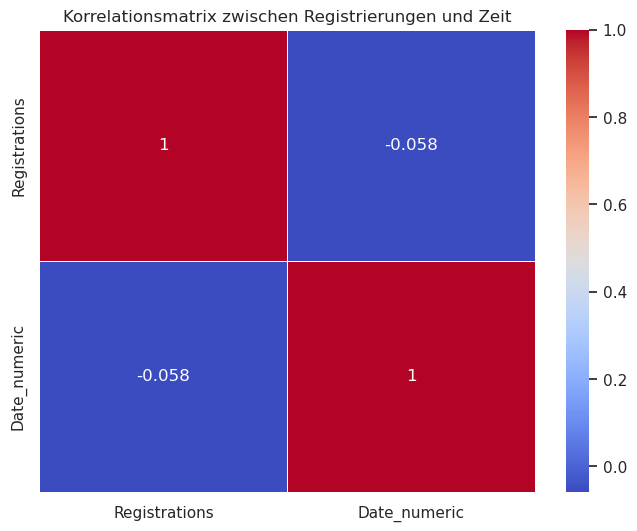

In [20]:
# Convert Date into Unix-Time
merged_data['Date_numeric'] = merged_data['Date'].apply(lambda x: x.timestamp())

# Creating a correlation matrix 
corr_matrix = merged_data[['Registrations', 'Date_numeric']].corr()

print("Korrelationsmatrix:")
print(corr_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Korrelationsmatrix zwischen Registrierungen und Zeit")
plt.show()

### E3-H2: Seasonal fluctuations in new registrations
Author: Robert Martinko 

Looking at the plot diagram Registration per Month (2000 to 2024), it is clear that there are small fluctuations throughout the whole diagram. In 2020, however, these fluctuations drastically dropped. From this, one could formulate the hypotehsis that there might be some seasonal fluctuations.

To be able to test this hypothesis and either confirm or disprove it, time series analyses and moving average models need to be developed.

In this case, this means first examining the seasonal decomposition to determine whether any patterns are detectable. Based on this output, further analyses will be conducted. Among other things, an investigation can be carried out to determine whether there are systematic deviations or anomalies. With the additional method of a moving average model, the rolling average over a specific time span will be examined. In these analyses, it may also be useful to examine the average registrations for individual months.

These analyses led to the conclusion that there are minimal seasonal fluctuations, though they cannot be attributed with 100% certainty. An explanation for the increase in registrations during the spring could be the release of new car models by the automotive industry. However, it is important to note that this is only a hypothesis and not a confirmed fact. The significant fluctuation in 2020 could be related to the COVID-19 pandemic. Furthermore, it is evident that the market only recovered relatively slowly.

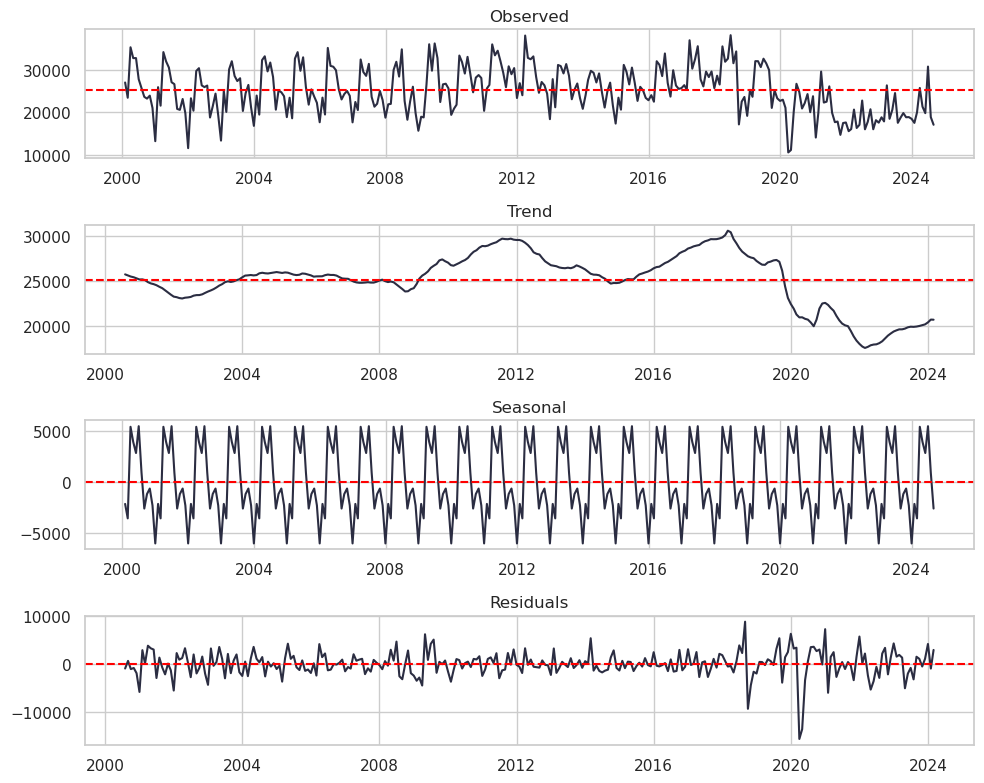

In [21]:
# setting 'Date' as an index
merged_data.set_index('Date', inplace=True)


# The data needed to be resampled in order to create the plot
monthly_data = merged_data['Registrations'].resample('ME').sum()

# Using a helpful function to create a decompostition from given data
decomposition = seasonal_decompose(monthly_data, model='additive')

observed_mean = decomposition.observed.mean()
trend_mean = decomposition.trend.mean()
seasonal_mean = decomposition.seasonal.mean()
resid_mean = decomposition.resid.mean()

# Ploting decompostions
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.axhline(observed_mean, color='red', linestyle='--', label='Mean Observed')
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.axhline(trend_mean, color='red', linestyle='--', label='Mean Observed')
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.axhline(seasonal_mean, color='red', linestyle='--', label='Mean Observed')
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.axhline(resid_mean, color='red', linestyle='--', label='Mean Observed')
plt.title('Residuals')

plt.tight_layout()
plt.savefig('plots/Dekompostions_Analyses.png', dpi=300)
plt.show()

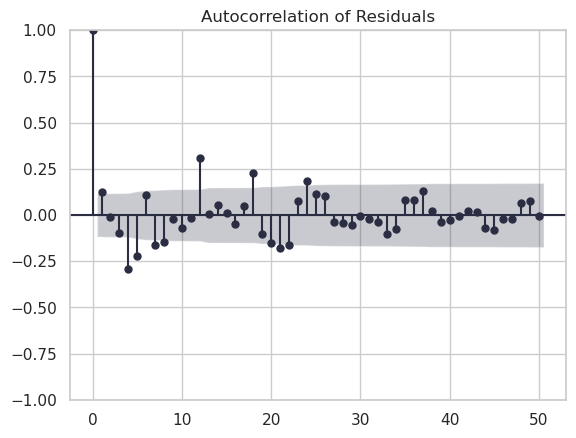

In [22]:
plot_acf(decomposition.resid.dropna(), lags=50)
plt.title('Autocorrelation of Residuals')
plt.grid(True)
plt.show()

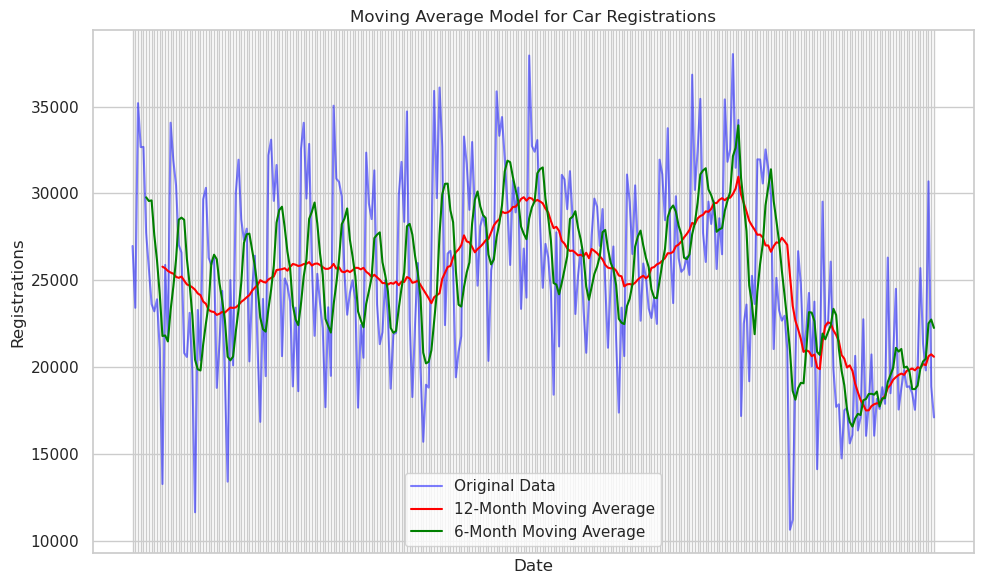

In [23]:
ma_12 = registrations_per_month.rolling(window=12).mean()
ma_6 = registrations_per_month.rolling(window=6).mean()

# Plot the original data with the moving averages
plt.figure(figsize=(10, 6))
plt.plot(registrations_per_month, label='Original Data', color='blue', alpha=0.5)
plt.plot(ma_12, label='12-Month Moving Average', color='red')
plt.plot(ma_6, label='6-Month Moving Average', color='green')
plt.title('Moving Average Model for Car Registrations')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.xlabel('Date')
plt.ylabel('Registrations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

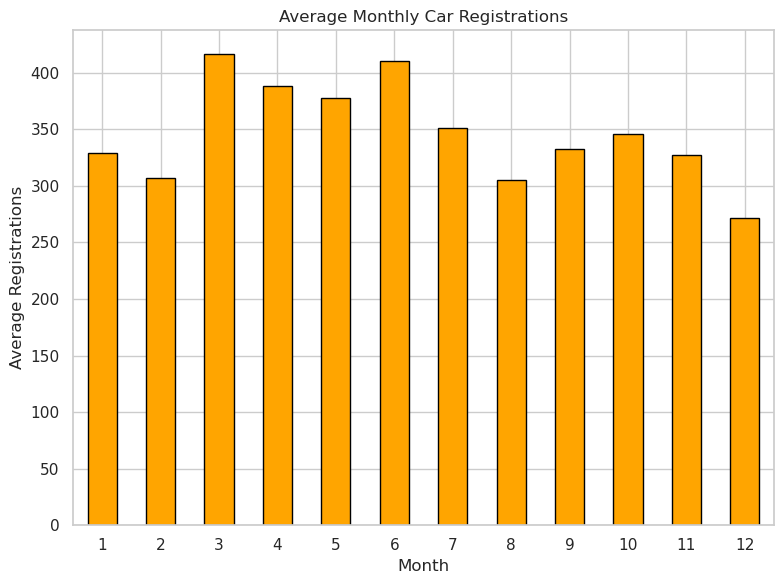

Date
1     328.805128
2     307.286203
3     416.660316
4     388.243968
5     377.279762
6     410.625269
7     351.217816
8     304.969466
9     332.636049
10    345.981754
11    327.078900
12    271.711824
Name: Registrations, dtype: float64

In [24]:
# Calculating the average registraions per month over the whole dataset 
average_monthly_registrations = merged_data.groupby(merged_data.index.month)['Registrations'].mean()

# Plot monthly car registrations
plt.figure(figsize=(8, 6))
average_monthly_registrations.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Average Monthly Car Registrations')
plt.ylabel('Average Registrations')
plt.xlabel('Month')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()

plt.savefig('plots/Average_Monthly_Car_Registration.png', dpi=300)
plt.show()

average_monthly_registrations